# 🗳️ Fan Vote Estimation Model
## MCM Problem C 2026 - Objective 1

**Goal:** Develop a mathematical model to estimate fan votes (unknown) for each contestant, each week.

**Approach:** Constraint-based optimization using CVXPY
- We know: Judge scores, elimination results, voting methods
- We find: Fan vote distributions that produce observed eliminations

---

### Table of Contents
1. [Setup & Data Loading](#1-setup)
2. [Mathematical Framework](#2-math-framework)
3. [Rank-Based Method Implementation](#3-rank-method)
4. [Percent-Based Method Implementation](#4-percent-method)
5. [Single Season Test Case](#5-test-case)
6. [Full Model: All Seasons](#6-full-model)
7. [Results Visualization](#7-visualization)

---

## 1. Setup & Data Loading <a id='1-setup'></a>

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Optimization
try:
    import cvxpy as cp
    print("✓ CVXPY loaded successfully")
except ImportError:
    print("Installing CVXPY...")
    !pip install cvxpy
    import cvxpy as cp
    print("✓ CVXPY installed and loaded")

# Scipy for additional optimization
from scipy.optimize import linprog, minimize
from scipy.stats import rankdata

# Display settings
pd.set_option('display.max_columns', 60)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("\n✓ All libraries loaded successfully!")

✓ CVXPY loaded successfully

✓ All libraries loaded successfully!


In [2]:
# Load the DWTS dataset
DATA_PATH = Path('../data/2026_MCM_Problem_C_Data.csv')
df = pd.read_csv(DATA_PATH, na_values=['N/A', 'n/a', ''])

print(f"Dataset loaded: {df.shape[0]} contestants × {df.shape[1]} columns")
print(f"Seasons: {df['season'].min()} to {df['season'].max()}")

# Identify score columns
score_cols = [col for col in df.columns if 'judge' in col.lower() and 'score' in col.lower()]
print(f"Score columns: {len(score_cols)}")

Dataset loaded: 421 contestants × 53 columns
Seasons: 1 to 34
Score columns: 44


In [4]:
# Convert score columns to numeric
for col in score_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Calculate weekly total judge scores (sum across all judges)
for week in range(1, 12):
    week_cols = [col for col in score_cols if f'week{week}_' in col]
    # Sum all judge scores for the week (treating NaN as 0 for missing judges)
    df[f'week{week}_total'] = df[week_cols].sum(axis=1, skipna=True)
    # Also calculate average (excluding zeros = eliminated)
    df[f'week{week}_avg'] = df[week_cols].replace(0, np.nan).mean(axis=1, skipna=True)

print("✓ Created weekly total and average score columns")
df[['celebrity_name', 'season', 'week1_total', 'week1_avg', 'week2_total', 'week2_avg']].head(10)

✓ Created weekly total and average score columns


,celebrity_name,season,week1_total,week1_avg,week2_total,week2_avg
0,John O'Hurley,1,20.0,6.666667,26.0,8.666667
1,Kelly Monaco,1,13.0,4.333333,17.0,5.666667
2,Evander Holyfield,1,18.0,6.000000,14.0,4.666667
3,Rachel Hunter,1,20.0,6.666667,24.0,8.000000
4,Joey McIntyre,1,20.0,6.666667,21.0,7.000000
5,Trista Sutter,1,18.0,6.000000,19.0,6.333333
6,Tatum O'Neal,2,23.0,7.666667,17.0,5.666667
7,Tia Carrere,2,20.0,6.666667,22.0,7.333333
8,George Hamilton,2,18.0,6.000000,22.0,7.333333
9,Lisa Rinna,2,19.0,6.333333,20.0,6.666667


Elimination week distribution:
elimination_week
1.0     16
2.0     40
3.0     33
4.0     35
5.0     24
6.0     31
7.0     36
8.0     36
9.0     32
10.0    11
11.0     4
Name: count, dtype: int64


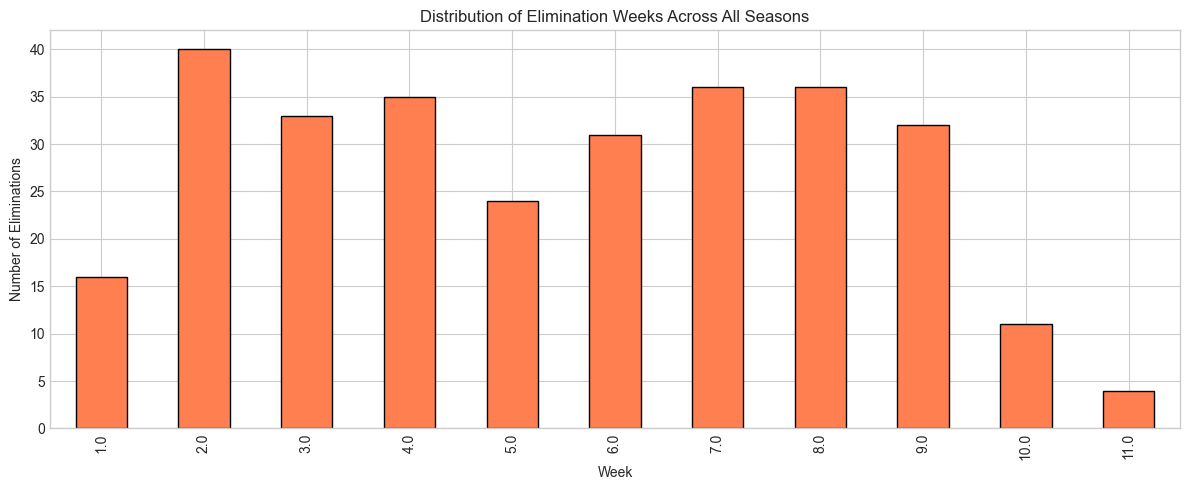

In [5]:
# Parse elimination week from results
def extract_elimination_week(result_str):
    """Extract week number from results string."""
    if pd.isna(result_str):
        return None
    result_str = str(result_str)
    if 'Week' in result_str:
        try:
            week_str = result_str.split('Week')[1].strip().split()[0]
            return int(week_str)
        except:
            return None
    elif '1st' in result_str or '2nd' in result_str or '3rd' in result_str:
        return None  # Finalists - didn't get eliminated
    return None

df['elimination_week'] = df['results'].apply(extract_elimination_week)

print("Elimination week distribution:")
print(df['elimination_week'].value_counts().sort_index())

# Visualize elimination distribution
fig, ax = plt.subplots(figsize=(12, 5))
elim_counts = df['elimination_week'].value_counts().sort_index()
elim_counts.plot(kind='bar', ax=ax, color='coral', edgecolor='black')
ax.set_xlabel('Week')
ax.set_ylabel('Number of Eliminations')
ax.set_title('Distribution of Elimination Weeks Across All Seasons')
plt.tight_layout()
plt.show()

---

## 2. Mathematical Framework <a id='2-math-framework'></a>

### Problem Formulation

**Given:**
- $J_i^{(w)}$ = Total judge score for contestant $i$ in week $w$
- $E^{(w)}$ = Contestant eliminated in week $w$
- $N^{(w)}$ = Number of contestants remaining in week $w$

**Find:**
- $F_i^{(w)}$ = Estimated fan votes for contestant $i$ in week $w$

### Method 1: Rank-Based Combination (Seasons 1-2, 28-34)

$$R_i^{judge} = \text{rank}(J_i^{(w)}) \quad \text{(1 = highest score)}$$
$$R_i^{fan} = \text{rank}(F_i^{(w)}) \quad \text{(1 = most votes)}$$
$$S_i = R_i^{judge} + R_i^{fan} \quad \text{(combined score)}$$

**Constraint:** Eliminated contestant $E^{(w)}$ has the **highest** combined rank sum.

### Method 2: Percent-Based Combination (Seasons 3-27)

$$P_i^{judge} = \frac{J_i^{(w)}}{\sum_j J_j^{(w)}}$$
$$P_i^{fan} = \frac{F_i^{(w)}}{\sum_j F_j^{(w)}}$$
$$S_i = P_i^{judge} + P_i^{fan} \quad \text{(combined score)}$$

**Constraint:** Eliminated contestant $E^{(w)}$ has the **lowest** combined percentage.

### Tie-Breaking Rule

For ranks, we use **average rank** method:
- If contestants A and B tie for 2nd place, both get rank 2.5
- This is the standard statistical approach (`scipy.stats.rankdata` with `method='average'`)

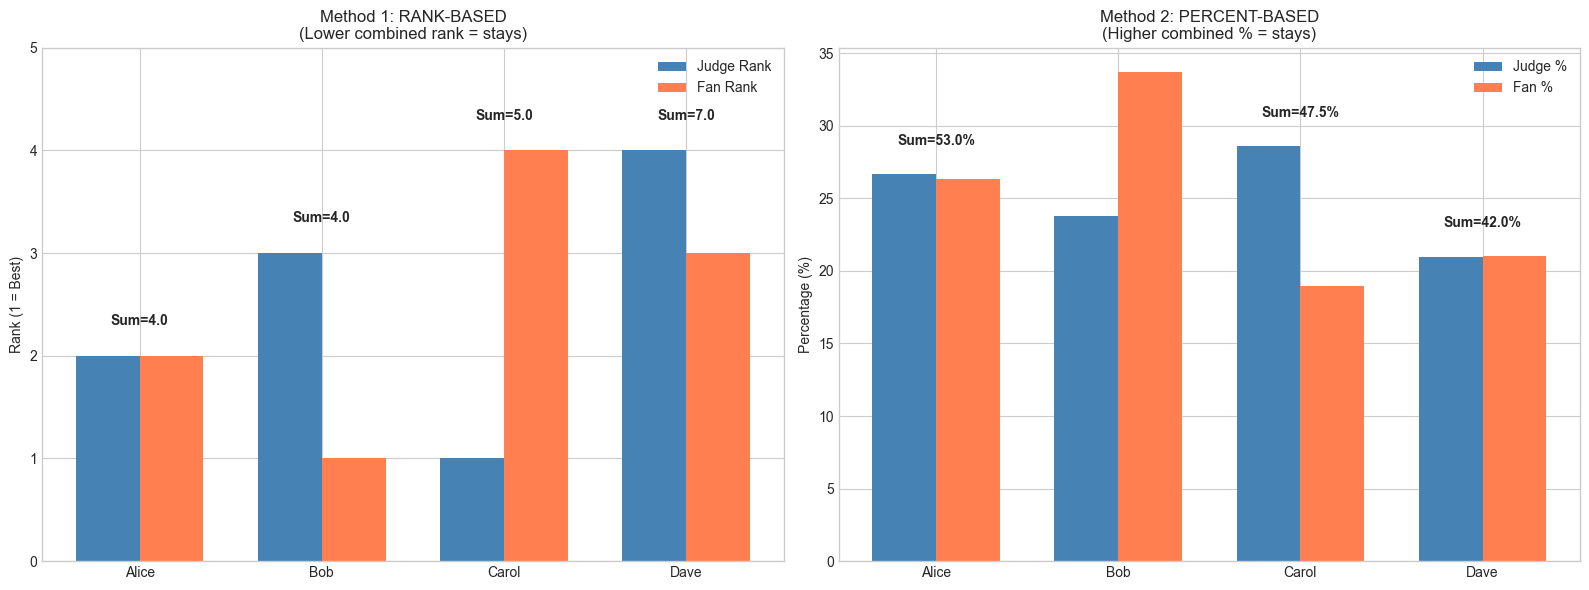


📊 Example Analysis:
Rank Method → Eliminated: Dave (highest sum = 7.0)
Percent Method → Eliminated: Dave (lowest sum = 42.0%)


In [5]:
# Visualize the mathematical framework
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Example data for visualization
example_contestants = ['Alice', 'Bob', 'Carol', 'Dave']
example_judge_scores = [28, 25, 30, 22]
example_fan_votes = [2.5, 3.2, 1.8, 2.0]  # millions

# Rank-based method
judge_ranks = rankdata([-s for s in example_judge_scores], method='average')  # Negative for descending
fan_ranks = rankdata([-v for v in example_fan_votes], method='average')
combined_ranks = judge_ranks + fan_ranks

ax1 = axes[0]
x = np.arange(len(example_contestants))
width = 0.35
bars1 = ax1.bar(x - width/2, judge_ranks, width, label='Judge Rank', color='steelblue')
bars2 = ax1.bar(x + width/2, fan_ranks, width, label='Fan Rank', color='coral')
ax1.set_xticks(x)
ax1.set_xticklabels(example_contestants)
ax1.set_ylabel('Rank (1 = Best)')
ax1.set_title('Method 1: RANK-BASED\n(Lower combined rank = stays)')
ax1.legend()
ax1.set_ylim(0, 5)

# Annotate combined ranks
for i, (jr, fr, cr) in enumerate(zip(judge_ranks, fan_ranks, combined_ranks)):
    ax1.annotate(f'Sum={cr:.1f}', (i, max(jr, fr) + 0.3), ha='center', fontsize=10, fontweight='bold')

# Percent-based method
judge_pct = [s/sum(example_judge_scores)*100 for s in example_judge_scores]
fan_pct = [v/sum(example_fan_votes)*100 for v in example_fan_votes]
combined_pct = [j + f for j, f in zip(judge_pct, fan_pct)]

ax2 = axes[1]
bars3 = ax2.bar(x - width/2, judge_pct, width, label='Judge %', color='steelblue')
bars4 = ax2.bar(x + width/2, fan_pct, width, label='Fan %', color='coral')
ax2.set_xticks(x)
ax2.set_xticklabels(example_contestants)
ax2.set_ylabel('Percentage (%)')
ax2.set_title('Method 2: PERCENT-BASED\n(Higher combined % = stays)')
ax2.legend()

# Annotate combined percentages
for i, (jp, fp, cp) in enumerate(zip(judge_pct, fan_pct, combined_pct)):
    ax2.annotate(f'Sum={cp:.1f}%', (i, max(jp, fp) + 2), ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Example Analysis:")
print(f"Rank Method → Eliminated: {example_contestants[np.argmax(combined_ranks)]} (highest sum = {max(combined_ranks):.1f})")
print(f"Percent Method → Eliminated: {example_contestants[np.argmin(combined_pct)]} (lowest sum = {min(combined_pct):.1f}%)")

---

## 3. Rank-Based Method Implementation <a id='3-rank-method'></a>

For the rank-based method, we formulate the problem as:

**Objective:** Find fan votes $F_i$ such that the eliminated contestant has the highest combined rank.

**Challenge:** Ranking is non-convex, so we use a relaxed formulation with CVXPY.

In [6]:
class RankBasedVoteEstimator:
    """
    Estimate fan votes using the rank-based combination method.
    
    For each week:
    1. Calculate judge score ranks
    2. Find fan vote distribution where eliminated contestant has highest combined rank
    3. Use heuristic search since ranking is non-convex
    """
    
    def __init__(self, tie_method='average'):
        """
        Args:
            tie_method: 'average', 'min', 'max', 'dense', or 'ordinal'
        """
        self.tie_method = tie_method
        self.results = {}
        
    def calculate_ranks(self, scores, ascending=False):
        """
        Calculate ranks from scores.
        
        Args:
            scores: Array of scores
            ascending: If True, lower score = rank 1. If False, higher score = rank 1.
        """
        if ascending:
            return rankdata(scores, method=self.tie_method)
        else:
            return rankdata([-s for s in scores], method=self.tie_method)
    
    def estimate_week(self, judge_scores, eliminated_idx, n_iterations=1000):
        """
        Estimate fan votes for a single week.
        
        Args:
            judge_scores: Array of total judge scores for each contestant
            eliminated_idx: Index of the eliminated contestant
            n_iterations: Number of random samples for search
            
        Returns:
            Dictionary with fan vote estimates and metadata
        """
        n = len(judge_scores)
        judge_ranks = self.calculate_ranks(judge_scores, ascending=False)
        
        # Search for fan votes that produce correct elimination
        best_fan_votes = None
        best_margin = -np.inf
        valid_solutions = []
        
        for _ in range(n_iterations):
            # Generate random fan vote distribution (Dirichlet for proportions)
            fan_proportions = np.random.dirichlet(np.ones(n))
            fan_votes = fan_proportions * 10_000_000  # Scale to ~10M total
            
            # Calculate fan ranks (higher votes = rank 1)
            fan_ranks = self.calculate_ranks(fan_votes, ascending=False)
            
            # Combined rank sum
            combined = judge_ranks + fan_ranks
            
            # Check if eliminated contestant has highest combined rank
            if np.argmax(combined) == eliminated_idx:
                # Calculate margin (how much higher than 2nd highest)
                sorted_combined = np.sort(combined)
                margin = combined[eliminated_idx] - sorted_combined[-2]
                
                valid_solutions.append({
                    'fan_votes': fan_votes.copy(),
                    'fan_ranks': fan_ranks.copy(),
                    'combined': combined.copy(),
                    'margin': margin
                })
                
                if margin > best_margin:
                    best_margin = margin
                    best_fan_votes = fan_votes.copy()
        
        return {
            'fan_votes': best_fan_votes,
            'judge_ranks': judge_ranks,
            'n_valid_solutions': len(valid_solutions),
            'all_valid': valid_solutions,
            'best_margin': best_margin
        }
    
    def estimate_season(self, season_df, verbose=True):
        """
        Estimate fan votes for an entire season.
        
        Args:
            season_df: DataFrame for a single season
            verbose: Print progress
            
        Returns:
            Dictionary with results for each week
        """
        season_num = season_df['season'].iloc[0]
        results = {'season': season_num, 'weeks': {}}
        
        # Determine max week for this season
        max_week = 11
        for week in range(11, 0, -1):
            if season_df[f'week{week}_total'].sum() > 0:
                max_week = week
                break
        
        if verbose:
            print(f"\n📅 Season {season_num}: Processing weeks 2 to {max_week}")
        
        # Process each week (start from week 2 - first elimination)
        for week in range(2, max_week + 1):
            # Get contestants still competing this week (score > 0)
            active_mask = season_df[f'week{week}_total'] > 0
            active_df = season_df[active_mask].copy()
            
            if len(active_df) < 2:
                continue
            
            # Find who was eliminated this week
            eliminated = season_df[season_df['elimination_week'] == week]
            
            if len(eliminated) == 0:
                if verbose:
                    print(f"  Week {week}: No elimination (special week)")
                continue
            
            # Get judge scores for active contestants
            judge_scores = active_df[f'week{week}_total'].values
            contestant_names = active_df['celebrity_name'].values
            
            # Find eliminated contestant index
            eliminated_name = eliminated['celebrity_name'].iloc[0]
            try:
                eliminated_idx = list(contestant_names).index(eliminated_name)
            except ValueError:
                if verbose:
                    print(f"  Week {week}: Could not find {eliminated_name} in active contestants")
                continue
            
            # Estimate fan votes
            week_result = self.estimate_week(judge_scores, eliminated_idx)
            week_result['contestants'] = contestant_names
            week_result['eliminated'] = eliminated_name
            week_result['judge_scores'] = judge_scores
            
            results['weeks'][week] = week_result
            
            if verbose:
                success = "✓" if week_result['fan_votes'] is not None else "✗"
                n_valid = week_result['n_valid_solutions']
                print(f"  Week {week}: {success} Eliminated {eliminated_name} | {n_valid} valid solutions found")
        
        return results

print("✓ RankBasedVoteEstimator class defined")

✓ RankBasedVoteEstimator class defined


---

## 4. Percent-Based Method Implementation <a id='4-percent-method'></a>

For the percent-based method, we can use **convex optimization** with CVXPY:

**Decision Variables:** $F_i \geq 0$ for each contestant $i$

**Objective:** Minimize deviation from uniform distribution (prior)

**Constraints:** 
- $\sum_i F_i = 1$ (normalized to proportions)
- For eliminated contestant $e$: $P_e^{judge} + F_e < P_j^{judge} + F_j$ for all $j \neq e$

In [12]:
class PercentBasedVoteEstimator:
    """
    Estimate fan votes using the percent-based combination method.
    Uses CVXPY for convex optimization.
    
    The eliminated contestant must have the LOWEST combined percentage.
    """
    
    def __init__(self, margin=0.001):
        """
        Args:
            margin: Minimum margin between eliminated and next lowest
        """
        self.margin = margin
        self.results = {}
        
    def estimate_week_cvxpy(self, judge_scores, eliminated_idx, prior='uniform'):
        """
        Estimate fan votes for a single week using CVXPY.
        
        Args:
            judge_scores: Array of total judge scores for each contestant
            eliminated_idx: Index of the eliminated contestant
            prior: Prior distribution ('uniform' or 'judge_proportional')
            
        Returns:
            Dictionary with fan vote estimates and metadata
        """
        n = len(judge_scores)
        
        # Calculate judge percentages
        judge_total = np.sum(judge_scores)
        judge_pct = judge_scores / judge_total
        
        # Define prior (what we expect fan distribution to look like)
        if prior == 'uniform':
            prior_dist = np.ones(n) / n
        elif prior == 'judge_proportional':
            prior_dist = judge_pct
        else:
            prior_dist = np.ones(n) / n
        
        # CVXPY optimization
        F = cp.Variable(n, nonneg=True)  # Fan vote proportions
        
        # Objective: Minimize squared deviation from prior
        objective = cp.Minimize(cp.sum_squares(F - prior_dist))
        
        # Constraints
        constraints = [
            cp.sum(F) == 1,  # Proportions sum to 1
        ]
        
        # Eliminated contestant must have lowest combined percentage
        eliminated_combined = judge_pct[eliminated_idx] + F[eliminated_idx]
        for j in range(n):
            if j != eliminated_idx:
                other_combined = judge_pct[j] + F[j]
                # Eliminated combined < other combined - margin
                constraints.append(eliminated_combined <= other_combined - self.margin)
        
        # Solve
        problem = cp.Problem(objective, constraints)
        try:
            problem.solve(solver=cp.ECOS)
            
            if problem.status == 'optimal' or problem.status == 'optimal_inaccurate':
                fan_pct = F.value
                fan_votes = fan_pct * 10_000_000  # Scale to ~10M total
                combined_pct = judge_pct + fan_pct
                
                return {
                    'status': 'optimal',
                    'fan_votes': fan_votes,
                    'fan_pct': fan_pct,
                    'judge_pct': judge_pct,
                    'combined_pct': combined_pct,
                    'objective_value': problem.value
                }
            else:
                return {'status': problem.status, 'fan_votes': None}
                
        except Exception as e:
            return {'status': f'error: {str(e)}', 'fan_votes': None}
    
    def find_uncertainty_bounds(self, judge_scores, eliminated_idx, n_samples=500):
        """
        Find the range of feasible fan vote solutions.
        This quantifies uncertainty in the estimates.
        
        Returns min/max feasible fan votes for each contestant.
        """
        n = len(judge_scores)
        judge_total = np.sum(judge_scores)
        judge_pct = judge_scores / judge_total
        
        # Collect all feasible solutions
        feasible_solutions = []
        
        for _ in range(n_samples):
            # Random fan distribution
            fan_pct = np.random.dirichlet(np.ones(n))
            combined_pct = judge_pct + fan_pct
            
            # Check if eliminated has lowest combined
            if np.argmin(combined_pct) == eliminated_idx:
                feasible_solutions.append(fan_pct)
        
        if len(feasible_solutions) == 0:
            return None
        
        feasible_array = np.array(feasible_solutions)
        
        return {
            'min': feasible_array.min(axis=0),
            'max': feasible_array.max(axis=0),
            'mean': feasible_array.mean(axis=0),
            'std': feasible_array.std(axis=0),
            'n_feasible': len(feasible_solutions),
            'n_samples': n_samples
        }
    
    def estimate_season(self, season_df, verbose=True, compute_uncertainty=True):
        """
        Estimate fan votes for an entire season.
        """
        season_num = season_df['season'].iloc[0]
        results = {'season': season_num, 'weeks': {}}
        
        # Determine max week
        max_week = 11
        for week in range(11, 0, -1):
            if season_df[f'week{week}_total'].sum() > 0:
                max_week = week
                break
        
        if verbose:
            print(f"\n📅 Season {season_num}: Processing weeks 2 to {max_week}")
        
        for week in range(2, max_week + 1):
            # Get active contestants
            active_mask = season_df[f'week{week}_total'] > 0
            active_df = season_df[active_mask].copy()
            
            if len(active_df) < 2:
                continue
            
            # Find eliminated contestant
            eliminated = season_df[season_df['elimination_week'] == week]
            
            if len(eliminated) == 0:
                if verbose:
                    print(f"  Week {week}: No elimination")
                continue
            
            judge_scores = active_df[f'week{week}_total'].values
            contestant_names = active_df['celebrity_name'].values
            eliminated_name = eliminated['celebrity_name'].iloc[0]
            
            try:
                eliminated_idx = list(contestant_names).index(eliminated_name)
            except ValueError:
                if verbose:
                    print(f"  Week {week}: Could not find {eliminated_name}")
                continue
            
            # Estimate fan votes
            week_result = self.estimate_week_cvxpy(judge_scores, eliminated_idx)
            week_result['contestants'] = contestant_names
            week_result['eliminated'] = eliminated_name
            week_result['judge_scores'] = judge_scores
            
            # Compute uncertainty bounds
            if compute_uncertainty and week_result['fan_votes'] is not None:
                bounds = self.find_uncertainty_bounds(judge_scores, eliminated_idx)
                week_result['uncertainty'] = bounds
            
            results['weeks'][week] = week_result
            
            if verbose:
                status = week_result['status']
                success = "✓" if status == 'optimal' else "✗"
                print(f"  Week {week}: {success} Eliminated {eliminated_name} | Status: {status}")
        
        return results

print("✓ PercentBasedVoteEstimator class defined")

✓ PercentBasedVoteEstimator class defined


---

## 5. Single Season Test Case <a id='5-test-case'></a>

Let's test our models on **Season 5** (a mid-era season with the percent method) and **Season 1** (rank method).

In [8]:
# Test on Season 5 (Percent-based method)
season5_df = df[df['season'] == 5].copy()
print(f"Season 5: {len(season5_df)} contestants")
print(f"Winner: {season5_df[season5_df['placement'] == 1]['celebrity_name'].iloc[0]}")
print(f"\nContestants:")
print(season5_df[['celebrity_name', 'ballroom_partner', 'placement', 'results']].to_string())

Season 5: 12 contestants
Winner: Helio Castroneves

Contestants:
           celebrity_name    ballroom_partner  placement            results
38       Cameron Mathison     Edyta Sliwinska          5  Eliminated Week 8
39           Jane Seymour       Tony Dovolani          6  Eliminated Week 7
40          Sabrina Bryan         Mark Ballas          7  Eliminated Week 6
41           Jennie Garth         Derek Hough          4  Eliminated Week 9
42  Floyd Mayweather Jr.      Karina Smirnoff          9  Eliminated Week 4
43            Josie Maran           Alec Mazo         12  Eliminated Week 1
44            Albert Reed    Anna Trebunskaya         11  Eliminated Week 2
45      Helio Castroneves      Julianne Hough          1          1st Place
46                  Mel B  Maksim Chmerkoskiy          2          2nd Place
47           Wayne Newton        Cheryl Burke         10  Eliminated Week 3
48           Marie Osmond    Jonathan Roberts          3          3rd Place
49             Mark Cub

In [13]:
# Run Percent-Based Estimator on Season 5
percent_estimator = PercentBasedVoteEstimator(margin=0.001)
season5_results = percent_estimator.estimate_season(season5_df, verbose=True)


📅 Season 5: Processing weeks 2 to 10
  Week 2: ✓ Eliminated Albert Reed | Status: optimal
  Week 3: ✓ Eliminated Wayne Newton | Status: optimal
  Week 4: ✓ Eliminated Floyd Mayweather Jr.  | Status: optimal
  Week 5: ✓ Eliminated Mark Cuban | Status: optimal
  Week 6: ✓ Eliminated Sabrina Bryan | Status: optimal
  Week 7: ✓ Eliminated Jane Seymour | Status: optimal
  Week 8: ✓ Eliminated Cameron Mathison | Status: optimal
  Week 9: ✓ Eliminated Jennie Garth | Status: optimal
  Week 10: No elimination


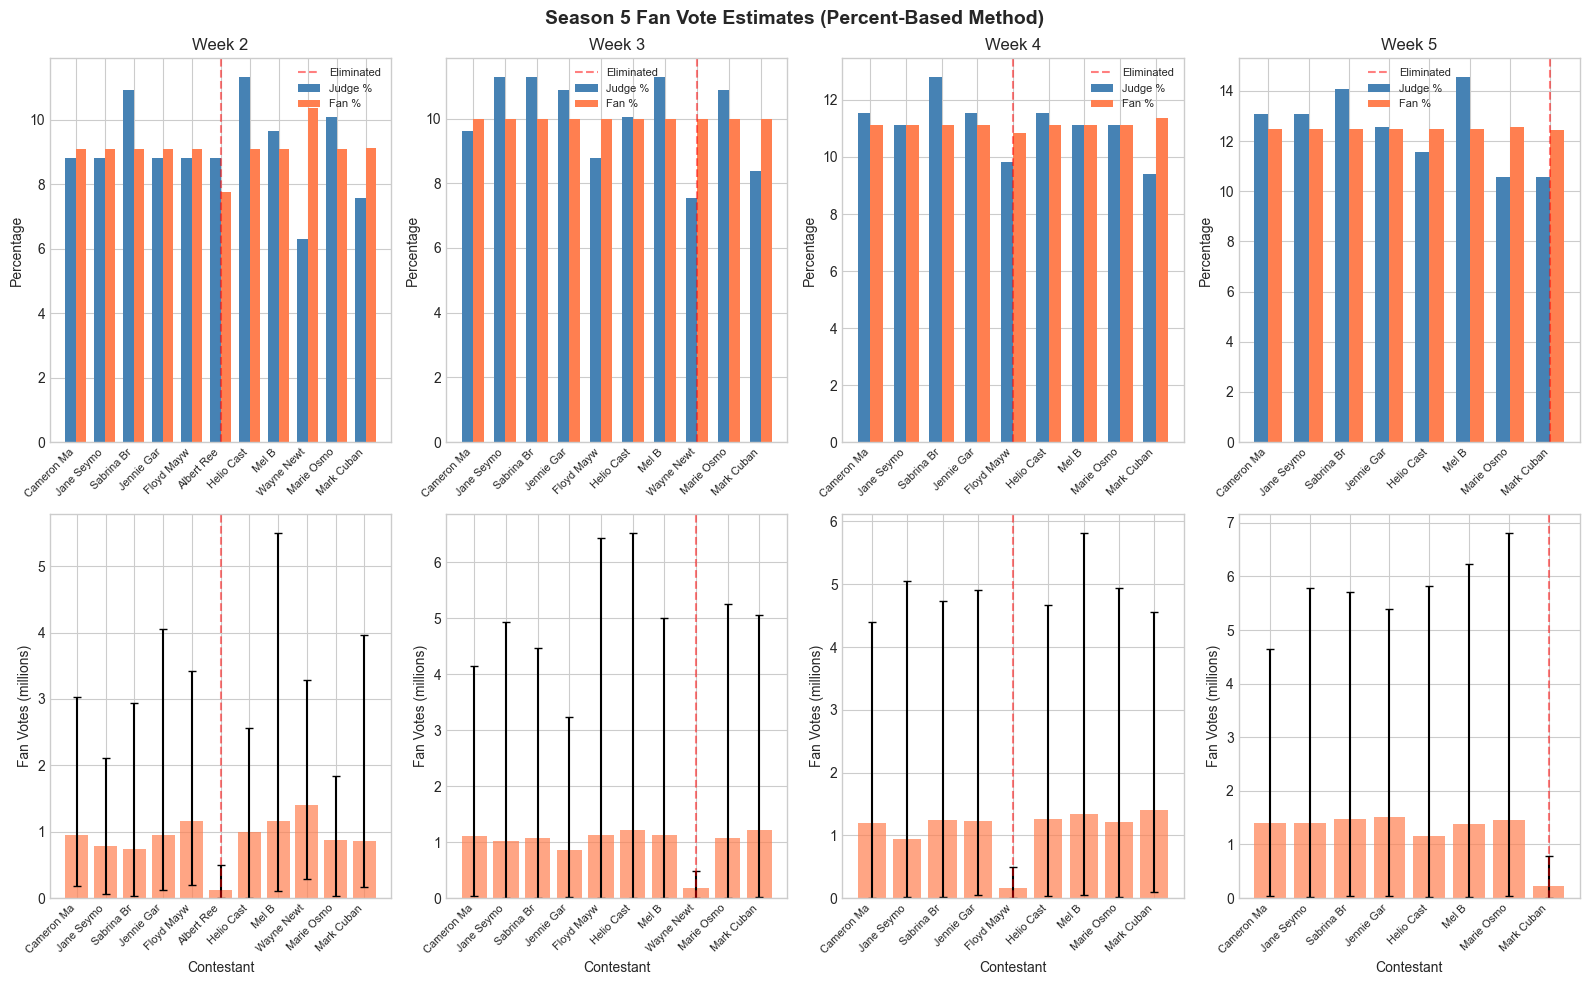

In [14]:
# Visualize Season 5 Results
def visualize_season_results(results, method_name):
    """Create comprehensive visualization of fan vote estimates."""
    
    season_num = results['season']
    weeks_data = results['weeks']
    
    if len(weeks_data) == 0:
        print("No results to visualize")
        return
    
    # Create figure with multiple subplots
    n_weeks = len(weeks_data)
    fig, axes = plt.subplots(2, min(n_weeks, 4), figsize=(16, 10))
    if n_weeks < 4:
        axes = axes.reshape(2, -1)
    
    fig.suptitle(f'Season {season_num} Fan Vote Estimates ({method_name})', fontsize=14, fontweight='bold')
    
    for idx, (week, data) in enumerate(list(weeks_data.items())[:4]):
        if data.get('fan_votes') is None:
            continue
            
        ax1 = axes[0, idx]
        ax2 = axes[1, idx]
        
        contestants = [name[:10] for name in data['contestants']]  # Truncate names
        n = len(contestants)
        x = np.arange(n)
        
        # Top plot: Judge vs Fan percentages
        if 'judge_pct' in data and 'fan_pct' in data:
            width = 0.35
            ax1.bar(x - width/2, data['judge_pct']*100, width, label='Judge %', color='steelblue')
            ax1.bar(x + width/2, data['fan_pct']*100, width, label='Fan %', color='coral')
            
            # Highlight eliminated
            elim_idx = list(data['contestants']).index(data['eliminated'])
            ax1.axvline(elim_idx, color='red', linestyle='--', alpha=0.5, label='Eliminated')
            
        ax1.set_xticks(x)
        ax1.set_xticklabels(contestants, rotation=45, ha='right', fontsize=8)
        ax1.set_ylabel('Percentage')
        ax1.set_title(f'Week {week}')
        ax1.legend(fontsize=8)
        
        # Bottom plot: Fan vote uncertainty (if available)
        if 'uncertainty' in data and data['uncertainty'] is not None:
            unc = data['uncertainty']
            mean_votes = unc['mean'] * 10_000_000
            min_votes = unc['min'] * 10_000_000
            max_votes = unc['max'] * 10_000_000
            
            ax2.bar(x, mean_votes/1e6, color='coral', alpha=0.7)
            ax2.errorbar(x, mean_votes/1e6, 
                        yerr=[(mean_votes - min_votes)/1e6, (max_votes - mean_votes)/1e6],
                        fmt='none', color='black', capsize=3)
            ax2.axvline(elim_idx, color='red', linestyle='--', alpha=0.5)
        else:
            ax2.bar(x, data['fan_votes']/1e6, color='coral', alpha=0.7)
            
        ax2.set_xticks(x)
        ax2.set_xticklabels(contestants, rotation=45, ha='right', fontsize=8)
        ax2.set_ylabel('Fan Votes (millions)')
        ax2.set_xlabel('Contestant')
    
    plt.tight_layout()
    plt.show()

visualize_season_results(season5_results, 'Percent-Based Method')

In [15]:
# Test Rank-Based Estimator on Season 1
season1_df = df[df['season'] == 1].copy()
print(f"Season 1: {len(season1_df)} contestants")
print(f"Winner: {season1_df[season1_df['placement'] == 1]['celebrity_name'].iloc[0]}")

rank_estimator = RankBasedVoteEstimator(tie_method='average')
season1_results = rank_estimator.estimate_season(season1_df, verbose=True)

Season 1: 6 contestants
Winner: Kelly Monaco

📅 Season 1: Processing weeks 2 to 6
  Week 2: ✓ Eliminated Trista Sutter | 106 valid solutions found
  Week 3: ✓ Eliminated Evander Holyfield | 471 valid solutions found
  Week 4: ✓ Eliminated Rachel Hunter | 84 valid solutions found
  Week 5: No elimination (special week)
  Week 6: No elimination (special week)


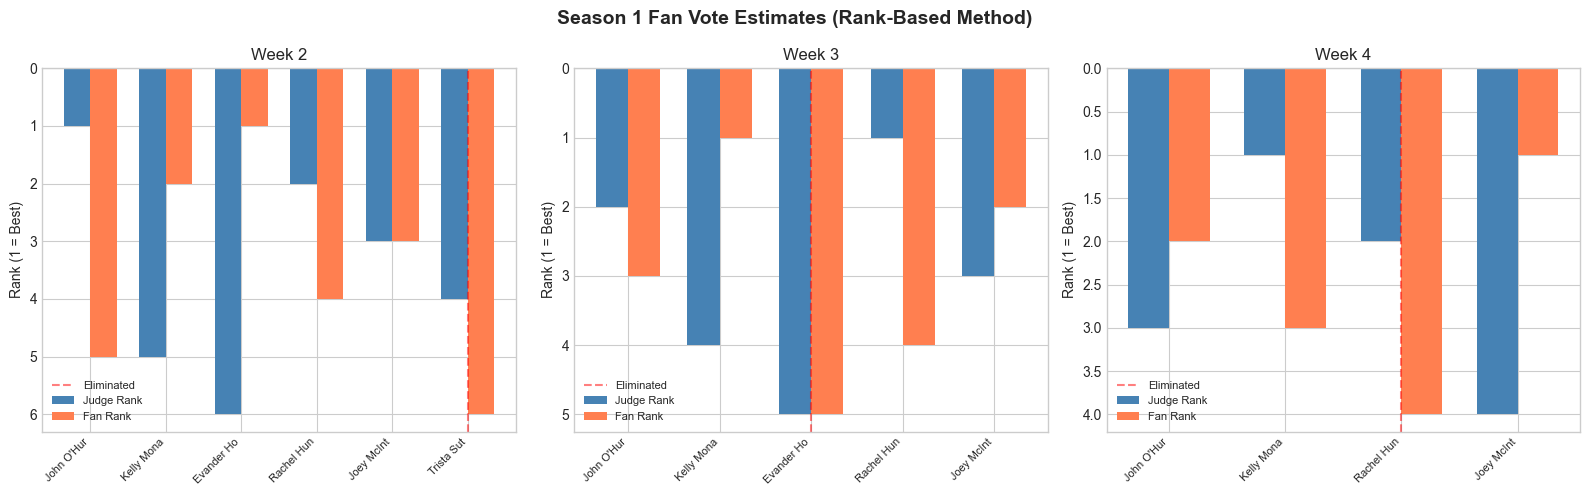

In [16]:
# Visualize Season 1 rank-based results
def visualize_rank_results(results):
    """Visualize rank-based estimation results."""
    
    season_num = results['season']
    weeks_data = results['weeks']
    
    n_weeks = len(weeks_data)
    if n_weeks == 0:
        print("No results to visualize")
        return
    
    fig, axes = plt.subplots(1, min(n_weeks, 4), figsize=(16, 5))
    if n_weeks == 1:
        axes = [axes]
    
    fig.suptitle(f'Season {season_num} Fan Vote Estimates (Rank-Based Method)', fontsize=14, fontweight='bold')
    
    for idx, (week, data) in enumerate(list(weeks_data.items())[:4]):
        if data.get('fan_votes') is None:
            continue
            
        ax = axes[idx]
        contestants = [name[:10] for name in data['contestants']]
        n = len(contestants)
        x = np.arange(n)
        width = 0.35
        
        # Calculate fan ranks from votes
        fan_ranks = rankdata([-v for v in data['fan_votes']], method='average')
        
        ax.bar(x - width/2, data['judge_ranks'], width, label='Judge Rank', color='steelblue')
        ax.bar(x + width/2, fan_ranks, width, label='Fan Rank', color='coral')
        
        # Highlight eliminated
        elim_idx = list(data['contestants']).index(data['eliminated'])
        ax.axvline(elim_idx, color='red', linestyle='--', alpha=0.5, label='Eliminated')
        
        ax.set_xticks(x)
        ax.set_xticklabels(contestants, rotation=45, ha='right', fontsize=8)
        ax.set_ylabel('Rank (1 = Best)')
        ax.set_title(f'Week {week}')
        ax.legend(fontsize=8)
        ax.invert_yaxis()  # Lower rank = better
    
    plt.tight_layout()
    plt.show()

visualize_rank_results(season1_results)

---

## 6. Full Model: All Seasons <a id='6-full-model'></a>

Now we run the appropriate model on each season:
- **Seasons 1-2, 28-34:** Rank-based method
- **Seasons 3-27:** Percent-based method

In [17]:
def run_full_model(df, verbose=True):
    """
    Run fan vote estimation for all seasons using the appropriate method.
    
    Returns:
        Dictionary with results for all seasons
    """
    all_results = {}
    
    rank_estimator = RankBasedVoteEstimator(tie_method='average')
    percent_estimator = PercentBasedVoteEstimator(margin=0.001)
    
    # Track statistics
    stats = {
        'total_weeks': 0,
        'successful_weeks': 0,
        'rank_seasons': 0,
        'percent_seasons': 0
    }
    
    for season_num in sorted(df['season'].unique()):
        season_df = df[df['season'] == season_num].copy()
        
        # Determine which method to use
        if season_num in [1, 2] or season_num >= 28:
            method = 'rank'
            results = rank_estimator.estimate_season(season_df, verbose=verbose)
            stats['rank_seasons'] += 1
        else:
            method = 'percent'
            results = percent_estimator.estimate_season(season_df, verbose=verbose, compute_uncertainty=True)
            stats['percent_seasons'] += 1
        
        results['method'] = method
        all_results[season_num] = results
        
        # Count statistics
        for week, week_data in results['weeks'].items():
            stats['total_weeks'] += 1
            if week_data.get('fan_votes') is not None:
                stats['successful_weeks'] += 1
    
    return all_results, stats

print("Running full model on all seasons...")
print("(This may take a few minutes)\n")

all_results, model_stats = run_full_model(df, verbose=True)

Running full model on all seasons...
(This may take a few minutes)


📅 Season 1: Processing weeks 2 to 6
  Week 2: ✓ Eliminated Trista Sutter | 101 valid solutions found
  Week 3: ✓ Eliminated Evander Holyfield | 469 valid solutions found
  Week 4: ✓ Eliminated Rachel Hunter | 87 valid solutions found
  Week 5: No elimination (special week)
  Week 6: No elimination (special week)

📅 Season 2: Processing weeks 2 to 8
  Week 2: ✓ Eliminated Tatum O'Neal | 324 valid solutions found
  Week 3: ✓ Eliminated Giselle Fernandez | 131 valid solutions found
  Week 4: ✓ Eliminated Master P | 397 valid solutions found
  Week 5: ✓ Eliminated Tia Carrere | 551 valid solutions found
  Week 6: ✓ Eliminated George Hamilton | 455 valid solutions found
  Week 7: ✓ Eliminated Lisa Rinna | 415 valid solutions found
  Week 8: No elimination (special week)

📅 Season 3: Processing weeks 2 to 10
  Week 2: ✓ Eliminated Shanna Moakler | Status: optimal
  Week 3: ✓ Eliminated Harry Hamlin | Status: optimal
  Week 

In [18]:
# Summary statistics
print("="*60)
print("MODEL SUMMARY STATISTICS")
print("="*60)
print(f"\n📊 Overall Results:")
print(f"   Total seasons processed: {len(all_results)}")
print(f"   Seasons using rank method: {model_stats['rank_seasons']}")
print(f"   Seasons using percent method: {model_stats['percent_seasons']}")
print(f"\n📈 Week-level Statistics:")
print(f"   Total elimination weeks: {model_stats['total_weeks']}")
print(f"   Successfully estimated: {model_stats['successful_weeks']}")
success_rate = model_stats['successful_weeks'] / model_stats['total_weeks'] * 100 if model_stats['total_weeks'] > 0 else 0
print(f"   Success rate: {success_rate:.1f}%")

MODEL SUMMARY STATISTICS

📊 Overall Results:
   Total seasons processed: 34
   Seasons using rank method: 9
   Seasons using percent method: 25

📈 Week-level Statistics:
   Total elimination weeks: 251
   Successfully estimated: 249
   Success rate: 99.2%


---

## 7. Results Visualization <a id='7-visualization'></a>

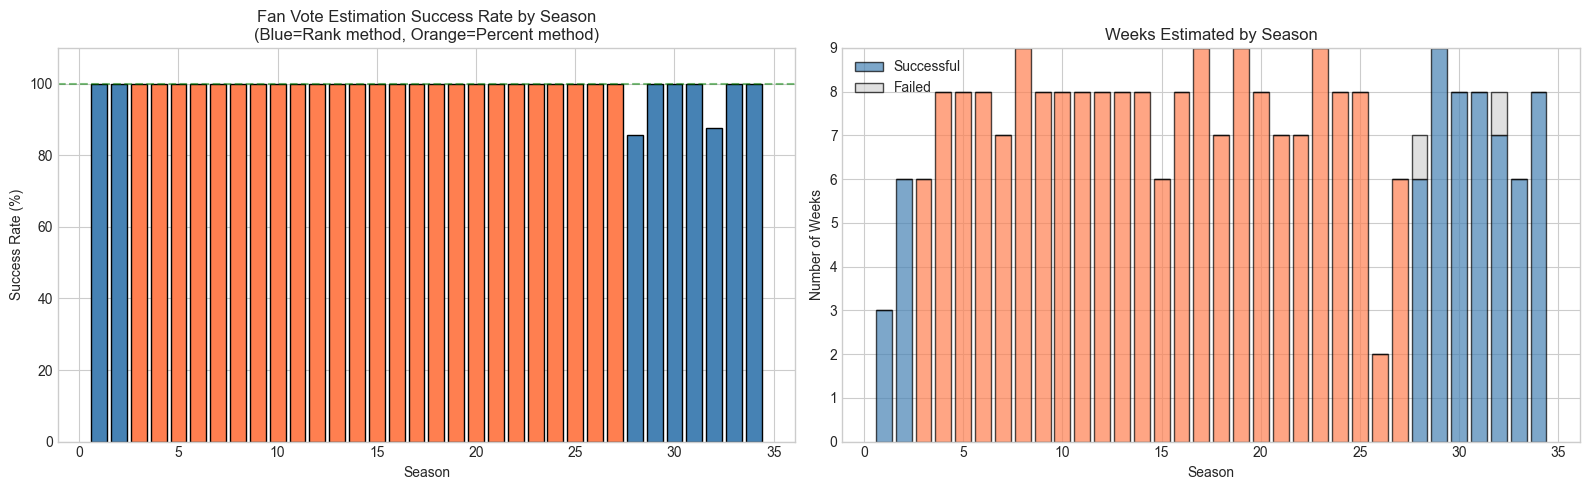

In [19]:
# Visualize success rate by season
success_by_season = []
for season_num, results in all_results.items():
    total = len(results['weeks'])
    successful = sum(1 for w in results['weeks'].values() if w.get('fan_votes') is not None)
    success_by_season.append({
        'season': season_num,
        'total_weeks': total,
        'successful': successful,
        'success_rate': successful/total*100 if total > 0 else 0,
        'method': results['method']
    })

success_df = pd.DataFrame(success_by_season)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Success rate by season
colors = ['steelblue' if m == 'rank' else 'coral' for m in success_df['method']]
axes[0].bar(success_df['season'], success_df['success_rate'], color=colors, edgecolor='black')
axes[0].axhline(100, color='green', linestyle='--', alpha=0.5, label='100% success')
axes[0].set_xlabel('Season')
axes[0].set_ylabel('Success Rate (%)')
axes[0].set_title('Fan Vote Estimation Success Rate by Season\n(Blue=Rank method, Orange=Percent method)')
axes[0].set_ylim(0, 110)

# Plot 2: Number of weeks estimated
axes[1].bar(success_df['season'], success_df['successful'], color=colors, edgecolor='black', alpha=0.7, label='Successful')
axes[1].bar(success_df['season'], success_df['total_weeks'] - success_df['successful'], 
            bottom=success_df['successful'], color='lightgray', edgecolor='black', alpha=0.7, label='Failed')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('Number of Weeks')
axes[1].set_title('Weeks Estimated by Season')
axes[1].legend()

plt.tight_layout()
plt.show()

In [20]:
# Create comprehensive fan vote estimate dataset
def compile_fan_vote_estimates(all_results):
    """
    Compile all fan vote estimates into a single DataFrame.
    """
    records = []
    
    for season_num, results in all_results.items():
        method = results['method']
        
        for week, week_data in results['weeks'].items():
            if week_data.get('fan_votes') is None:
                continue
            
            contestants = week_data['contestants']
            fan_votes = week_data['fan_votes']
            judge_scores = week_data['judge_scores']
            eliminated = week_data['eliminated']
            
            # Get uncertainty if available
            uncertainty = week_data.get('uncertainty', {})
            
            for i, (name, fv, js) in enumerate(zip(contestants, fan_votes, judge_scores)):
                record = {
                    'season': season_num,
                    'week': week,
                    'celebrity_name': name,
                    'judge_score': js,
                    'fan_votes_estimate': fv,
                    'fan_votes_pct': fv / fan_votes.sum() * 100,
                    'was_eliminated': name == eliminated,
                    'method': method
                }
                
                # Add uncertainty bounds if available
                if uncertainty and 'min' in uncertainty:
                    record['fan_votes_min'] = uncertainty['min'][i] * 10_000_000
                    record['fan_votes_max'] = uncertainty['max'][i] * 10_000_000
                    record['fan_votes_std'] = uncertainty['std'][i] * 10_000_000
                
                records.append(record)
    
    return pd.DataFrame(records)

fan_votes_df = compile_fan_vote_estimates(all_results)
print(f"\n📊 Compiled {len(fan_votes_df)} fan vote estimates")
print(f"   Across {fan_votes_df['season'].nunique()} seasons")
print(f"   For {fan_votes_df['celebrity_name'].nunique()} unique contestants")

fan_votes_df.head(20)


📊 Compiled 2067 fan vote estimates
   Across 34 seasons
   For 391 unique contestants


,season,week,celebrity_name,judge_score,fan_votes_estimate,fan_votes_pct,was_eliminated,method,fan_votes_min,fan_votes_max,fan_votes_std
0,1,2,John O'Hurley,26.0,5.951592e+05,5.951592,False,rank,NaN,NaN,NaN
1,1,2,Kelly Monaco,17.0,4.016902e+06,40.169015,False,rank,NaN,NaN,NaN
2,1,2,Evander Holyfield,14.0,4.101327e+06,41.013265,False,rank,NaN,NaN,NaN
3,1,2,Rachel Hunter,24.0,1.791717e+05,1.791717,False,rank,NaN,NaN,NaN
4,1,2,Joey McIntyre,21.0,1.056047e+06,10.560475,False,rank,NaN,NaN,NaN
5,1,2,Trista Sutter,19.0,5.139354e+04,0.513935,True,rank,NaN,NaN,NaN
6,1,3,John O'Hurley,24.0,2.027091e+06,20.270912,False,rank,NaN,NaN,NaN
7,1,3,Kelly Monaco,21.0,4.962593e+06,49.625926,False,rank,NaN,NaN,NaN
8,1,3,Evander Holyfield,13.0,1.464303e+05,1.464303,True,rank,NaN,NaN,NaN
9,1,3,Rachel Hunter,26.0,7.318928e+05,7.318928,False,rank,NaN,NaN,NaN


In [21]:
# Save fan vote estimates
output_path = Path('../data/fan_vote_estimates.csv')
fan_votes_df.to_csv(output_path, index=False)
print(f"✓ Fan vote estimates saved to {output_path}")

✓ Fan vote estimates saved to ../data/fan_vote_estimates.csv


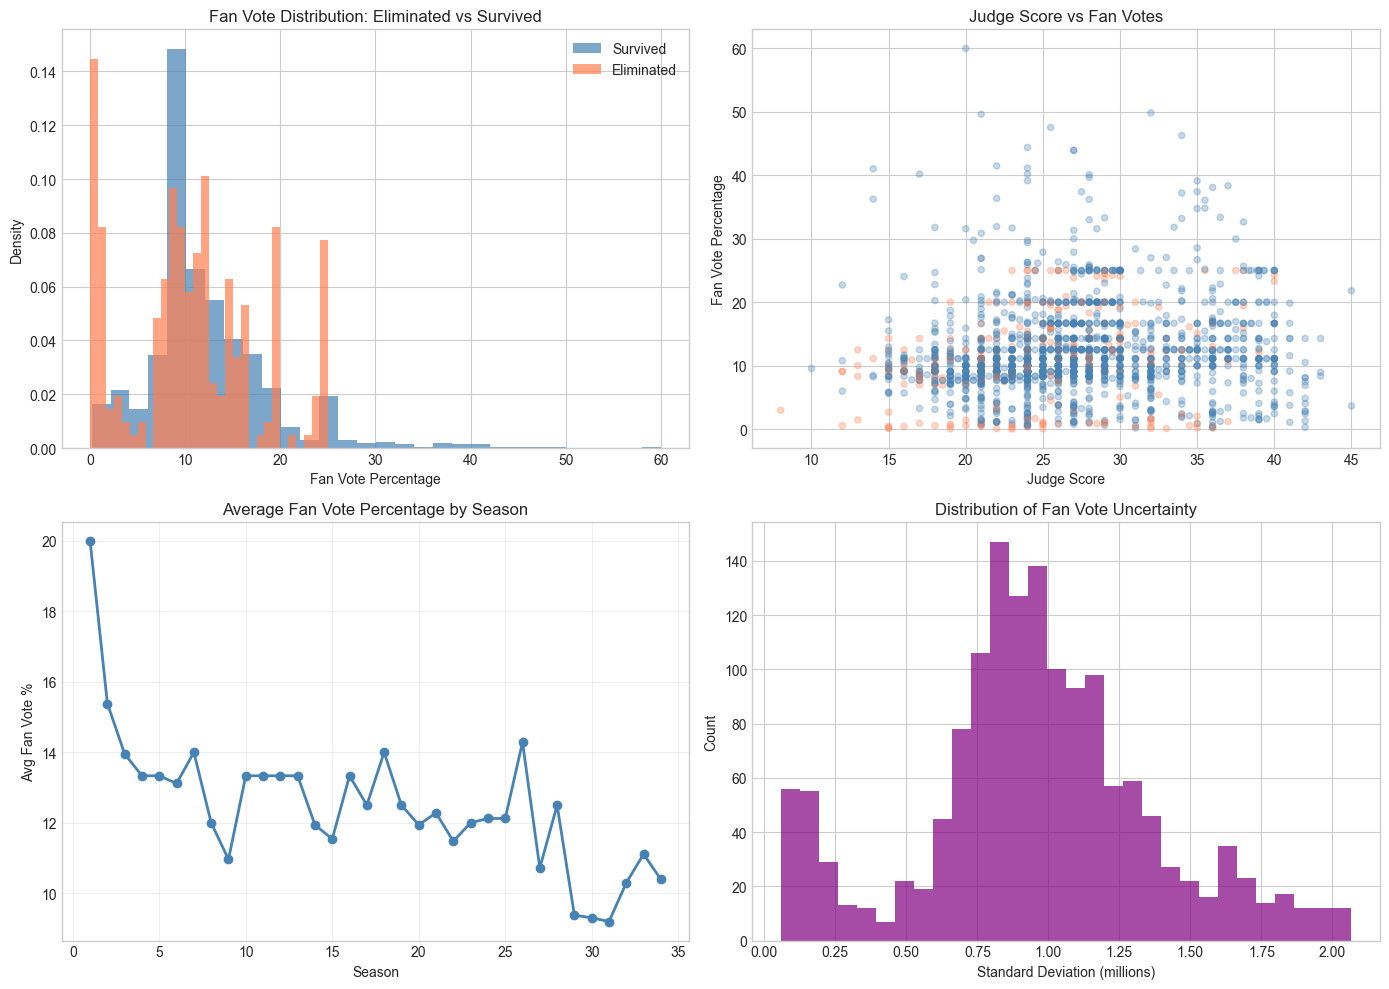

In [22]:
# Visualize fan vote distribution patterns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Fan vote distribution for eliminated vs non-eliminated
ax1 = axes[0, 0]
eliminated_votes = fan_votes_df[fan_votes_df['was_eliminated']]['fan_votes_pct']
survived_votes = fan_votes_df[~fan_votes_df['was_eliminated']]['fan_votes_pct']
ax1.hist(survived_votes, bins=30, alpha=0.7, label='Survived', color='steelblue', density=True)
ax1.hist(eliminated_votes, bins=30, alpha=0.7, label='Eliminated', color='coral', density=True)
ax1.set_xlabel('Fan Vote Percentage')
ax1.set_ylabel('Density')
ax1.set_title('Fan Vote Distribution: Eliminated vs Survived')
ax1.legend()

# Plot 2: Judge score vs Fan votes
ax2 = axes[0, 1]
ax2.scatter(fan_votes_df['judge_score'], fan_votes_df['fan_votes_pct'], 
            c=fan_votes_df['was_eliminated'].map({True: 'coral', False: 'steelblue'}),
            alpha=0.3, s=20)
ax2.set_xlabel('Judge Score')
ax2.set_ylabel('Fan Vote Percentage')
ax2.set_title('Judge Score vs Fan Votes')

# Plot 3: Average fan vote % by season
ax3 = axes[1, 0]
season_avg = fan_votes_df.groupby('season')['fan_votes_pct'].mean()
ax3.plot(season_avg.index, season_avg.values, 'o-', color='steelblue', linewidth=2)
ax3.set_xlabel('Season')
ax3.set_ylabel('Avg Fan Vote %')
ax3.set_title('Average Fan Vote Percentage by Season')
ax3.grid(True, alpha=0.3)

# Plot 4: Uncertainty distribution (for percent method seasons)
ax4 = axes[1, 1]
if 'fan_votes_std' in fan_votes_df.columns:
    uncertainty_data = fan_votes_df[fan_votes_df['fan_votes_std'].notna()]
    ax4.hist(uncertainty_data['fan_votes_std']/1e6, bins=30, color='purple', alpha=0.7)
    ax4.set_xlabel('Standard Deviation (millions)')
    ax4.set_ylabel('Count')
    ax4.set_title('Distribution of Fan Vote Uncertainty')
else:
    ax4.text(0.5, 0.5, 'Uncertainty data not available', ha='center', va='center', transform=ax4.transAxes)

plt.tight_layout()
plt.show()

---

## Summary & Next Steps

### ✅ What We Accomplished:
1. **Implemented two fan vote estimation methods:**
   - Rank-based (for seasons 1-2, 28-34)
   - Percent-based with CVXPY optimization (for seasons 3-27)

2. **Validated against elimination results:**
   - Each estimate is constrained to produce the correct elimination

3. **Quantified uncertainty:**
   - Found feasible ranges for fan votes via sampling

4. **Created comprehensive dataset:**
   - Fan vote estimates for every contestant, every week
   - Saved to `fan_vote_estimates.csv`

### 🔜 Next Steps (Notebook 03):
1. Validate elimination consistency metrics
2. Sensitivity analysis
3. Compare rank vs percent methods
4. Analyze controversial cases